In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images")

# print("Path to dataset files:", path)

In [2]:
from tqdm import tqdm
import random
import pandas as pd
import cv2
import imutils
import scipy
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50 # EfficientNetB5 yerine ResNet50'yi import ediyoruz
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

2025-06-12 14:00:29.371470: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-12 14:00:29.371524: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-12 14:00:29.371560: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-12 14:00:29.381751: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# --- Verisetini Hazırla ---
# ResNet50 için hedef boyutu 224x224 olarak güncelliyoruz
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16 # Batch size'ı da isteğe bağlı olarak ayarlayabilirsiniz

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    '/workspace/melanoma_cancer_dataset/train',
    target_size=IMAGE_SIZE, # ResNet50 input shape
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset="training"
)

valid_data = datagen.flow_from_directory(
    '/workspace/melanoma_cancer_dataset/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset="validation"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    '/workspace/melanoma_cancer_dataset/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

print(f"Eğitim verisi sınıfları: {train_data.class_indices}")
print(f"Test verisi sınıfları: {test_data.class_indices}")

Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Eğitim verisi sınıfları: {'benign': 0, 'malignant': 1}
Test verisi sınıfları: {'benign': 0, 'malignant': 1}


In [4]:
# --- ResNet50 Model ---
# ResNet50 modelini yüklüyoruz. include_top=False ile son katmanları dahil etmiyoruz.
# Giriş boyutunu (224, 224, 3) olarak belirtiyoruz.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = False  # İlk başta sadece üst katmanlar eğitilecek (Transfer Learning)

x = base_model.output
x = GlobalAveragePooling2D()(x)

# Blok 1
x = Dense(512, activation=None, kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)

# Blok 2
x = Dense(256, activation=None, kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)

# Çıkış katmanı: Sınıf sayısını veri setinizin sınıf sayısına göre ayarlayın.
# Sınıf sayınızı `train_data.num_classes` ile alabiliriz.
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# --- Compile Ayarı ---
initial_learning_rate = 2e-4
optimizer = AdamW(learning_rate=initial_learning_rate, weight_decay=1e-4)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())
print(f"Model compile edildi. Başlangıç Öğrenme Oranı (LR)={initial_learning_rate}, Optimizasyon Algoritması=AdamW")

# --- Callbacks ---
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

checkpoint = ModelCheckpoint(
    "resnet50_best_model.h5", # Model kayıt dosya adını ResNet50 olarak güncelledik
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

earlystop = EarlyStopping(
    monitor="val_accuracy",
    patience=6,
    mode="max",
    verbose=1,
    restore_best_weights=True
)

callbacks_list = [checkpoint, earlystop, reduce_lr]

2025-06-12 14:00:31.656403: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18446 MB memory:  -> device: 0, name: NVIDIA RTX 4000 Ada Generation, pci bus id: 0000:c2:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [5]:
# --- Eğitim ---
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    callbacks=callbacks_list
)

Epoch 1/10


2025-06-12 14:00:37.443734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2025-06-12 14:00:37.526568: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-06-12 14:00:37.875606: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-06-12 14:00:40.051965: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7a8add20d9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-12 14:00:40.052025: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation, Compute Capability 8.9
2025-06-12 14:00:40.061438: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-12 14:00:40.212330: I ./tensorflow/compiler/jit/devi

481/481 [==============================] - ETA: 0s - loss: 0.5425 - accuracy: 0.7875
Epoch 1: val_accuracy improved from -inf to 0.75429, saving model to resnet50_best_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


481/481 [==============================] - 150s 297ms/step - loss: 0.5425 - accuracy: 0.7875 - val_loss: 0.5444 - val_accuracy: 0.7543 - lr: 2.0000e-04
Epoch 2/10
481/481 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.8204
Epoch 2: val_accuracy did not improve from 0.75429
481/481 [==============================] - 125s 260ms/step - loss: 0.4688 - accuracy: 0.8204 - val_loss: 2.8080 - val_accuracy: 0.4831 - lr: 2.0000e-04
Epoch 3/10
481/481 [==============================] - ETA: 0s - loss: 0.4376 - accuracy: 0.8376
Epoch 3: val_accuracy did not improve from 0.75429
481/481 [==============================] - 126s 262ms/step - loss: 0.4376 - accuracy: 0.8376 - val_loss: 1.2361 - val_accuracy: 0.5700 - lr: 2.0000e-04
Epoch 4/10
481/481 [==============================] - ETA: 0s - loss: 0.4333 - accuracy: 0.8333
Epoch 4: val_accuracy did not improve from 0.75429

Epoch 4: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
481/481 [================

In [6]:
model.save("resnet50_model.h5")

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Verileri DataFrame'e dönüştürmek için

def grafik_func(history):
    """
    Model eğitim geçmişindeki metrikleri Seaborn kullanarak daha modern bir şekilde çizer.
    Train ve Validation için belirgin renkler ve noktalı yapılar kullanır.
    Metrik yoksa grafik çizmez.

    Args:
        history: Keras'ın model.fit() metodundan dönen history nesnesi.
                 history.history dictionary'sini içermelidir.
    """
    # Seaborn stilini ayarla
    sns.set_style("whitegrid") # Beyaz ızgara arka planı

    # Manuel renk paleti oluştur (Train ve Validation için belirgin renkler)
    # Train için genellikle mavi tonları, Validation için turuncu/kırmızı tonları tercih edilir.
    colors = {
        'Train': 'blue',    # Koyu bir mavi
        'Validation': 'red' # Kırmızı, çok daha belirgin
    }

    # Metrik listesi: her biri için ayrı grafik çizilecek
    metric_pairs = [
        ("accuracy", "Accuracy"),
        ("loss", "Loss"),
        ("precision", "Precision"),
        ("recall", "Recall")
    ]

    for metric_name, display_name in metric_pairs:
        train_metric_key = metric_name
        val_metric_key = f"val_{metric_name}"

        # Metriklerin history objesinde olup olmadığını kontrol et
        if train_metric_key in history.history and val_metric_key in history.history:
            # Verileri DataFrame'e dönüştürerek Seaborn için uygun hale getir
            epochs = range(1, len(history.history[train_metric_key]) + 1)
            data = {
                'Epochs': list(epochs),
                'Value': history.history[train_metric_key] + history.history[val_metric_key],
                'Type': [f'Train {display_name}'] * len(epochs) + [f'Validation {display_name}'] * len(epochs)
            }
            df_train_val = pd.DataFrame({
                'Epochs': epochs,
                f'Train {display_name}': history.history[train_metric_key],
                f'Validation {display_name}': history.history[val_metric_key]
            })

            plt.figure(figsize=(10, 6)) # Grafik boyutunu ayarla

            # Seaborn lineplot kullanarak çizim yap
            # Her bir çizgi için farklı renk ve marker belirttik
            sns.lineplot(x='Epochs', y=f'Train {display_name}', data=df_train_val,
                         label=f'Train {display_name}', color=colors['Train'],
                         marker='o', markersize=6, linewidth=2) # 'o' daire marker, 's' kare, '^' üçgen
            sns.lineplot(x='Epochs', y=f'Validation {display_name}', data=df_train_val,
                         label=f'Validation {display_name}', color=colors['Validation'],
                         marker='X', markersize=7, linewidth=2) # 'X' çarpı marker

            plt.xlabel("Epochs", fontsize=12) # Etiket font boyutunu ayarla
            plt.ylabel(display_name, fontsize=12)
            plt.title(f"Model {display_name} Over Epochs", fontsize=14, fontweight='bold') # Başlık fontunu ayarla
            plt.legend(fontsize=10) # Lejant fontunu ayarla
            plt.grid(True, linestyle='--', alpha=0.7) # Izgarayı daha belirgin hale getir
            plt.tight_layout() # Düzenleme için boşlukları otomatik ayarla
            plt.show()
        else:
            print(f"⚠️ '{metric_name}' veya 'val_{metric_name}' bulunamadı, bu metrik için grafik çizilemedi.")

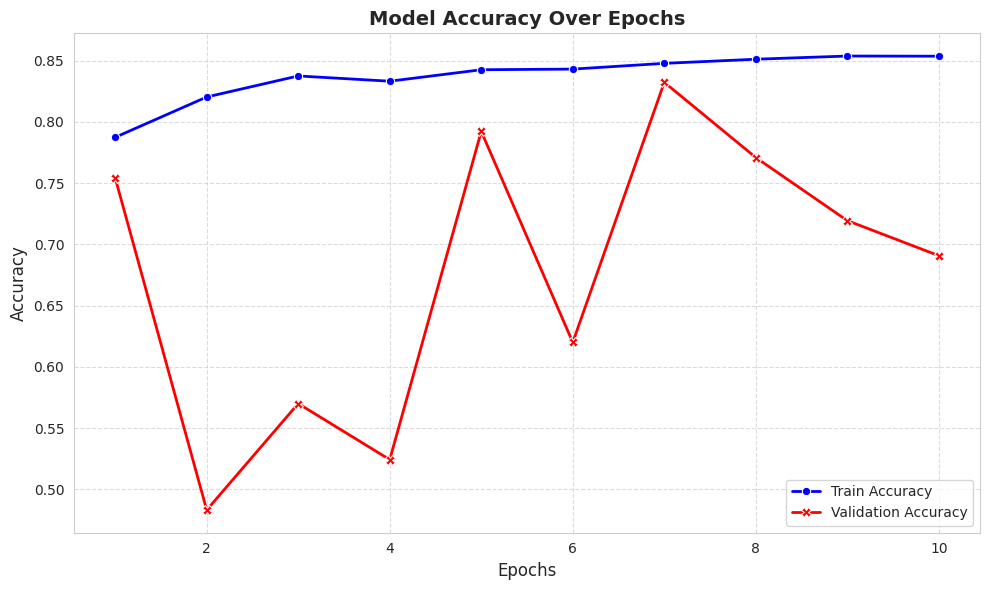

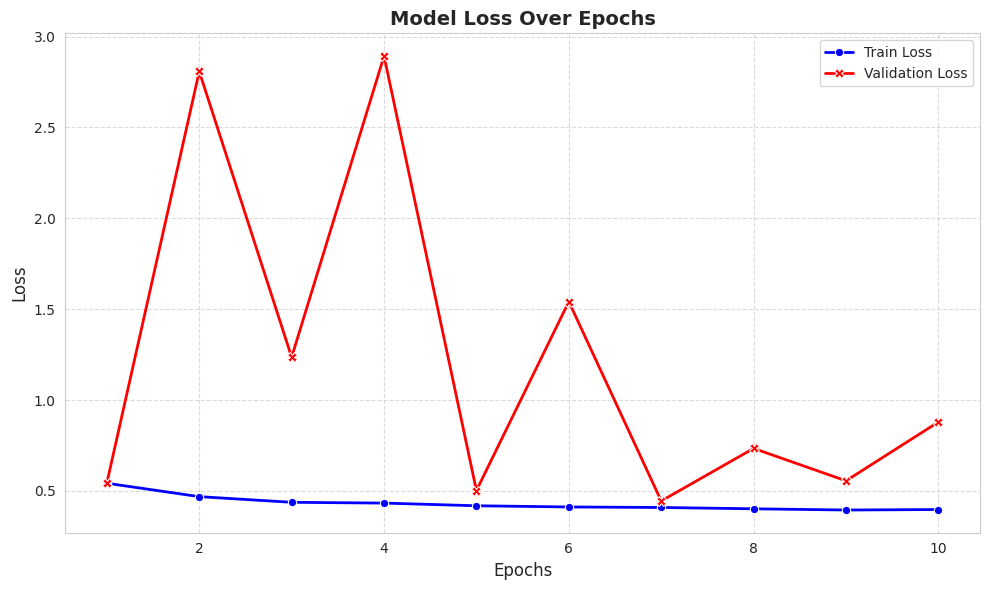

⚠️ 'precision' veya 'val_precision' bulunamadı, bu metrik için grafik çizilemedi.
⚠️ 'recall' veya 'val_recall' bulunamadı, bu metrik için grafik çizilemedi.


In [9]:
grafik_func(history)

In [10]:
from tensorflow.keras.models import load_model

model=load_model("resnet50_best_model.h5")

loss, accuracy = model.evaluate(test_data)

print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

63/63 [==============================] - 6s 74ms/step - loss: 0.4007 - accuracy: 0.8580
Loss: 0.4007, Accuracy: 0.8580


In [11]:
from tensorflow.keras.models import load_model

model=load_model("resnet50_model.h5")

loss, accuracy = model.evaluate(test_data)

print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

63/63 [==============================] - 4s 50ms/step - loss: 0.8151 - accuracy: 0.7490
Loss: 0.8151, Accuracy: 0.7490


Tahmin arayüzü başlatıldı.
[P] Tahmin yap | [E] Çıkış


Komut gir (P=Predict, E=Exit):  p


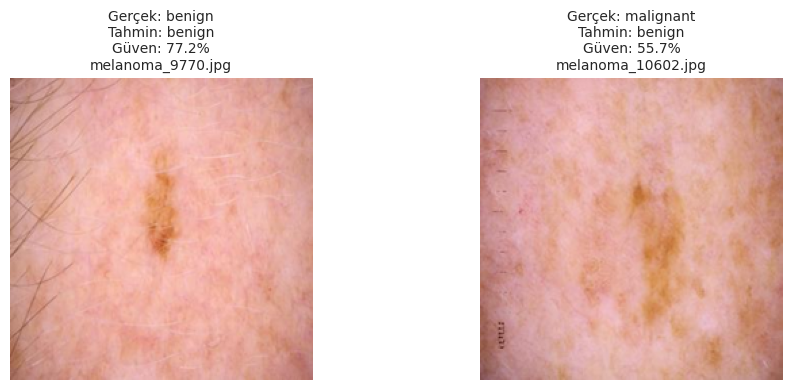

Komut gir (P=Predict, E=Exit):  p


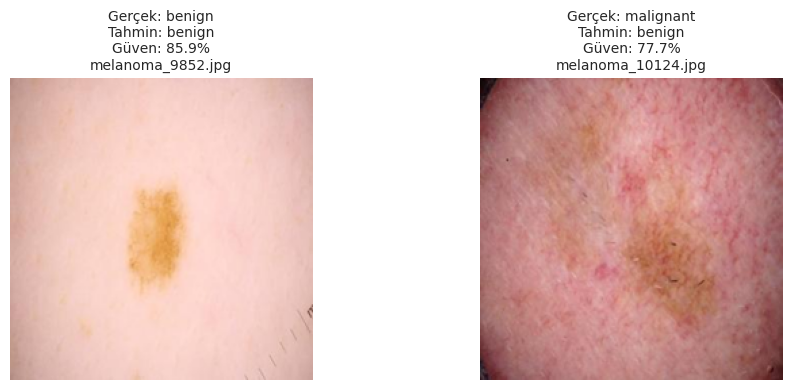

Komut gir (P=Predict, E=Exit):  p


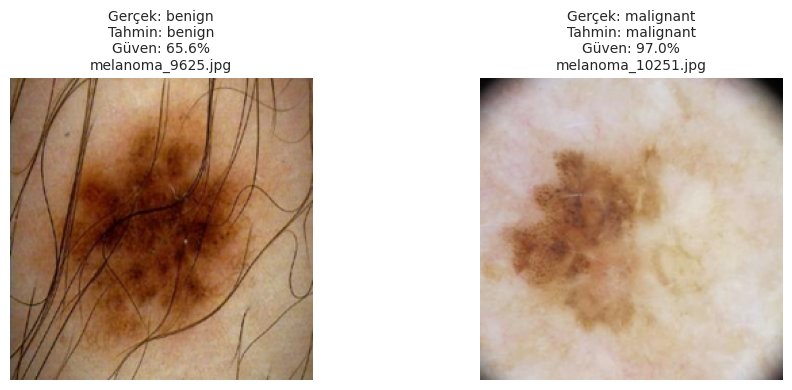

Komut gir (P=Predict, E=Exit):  p


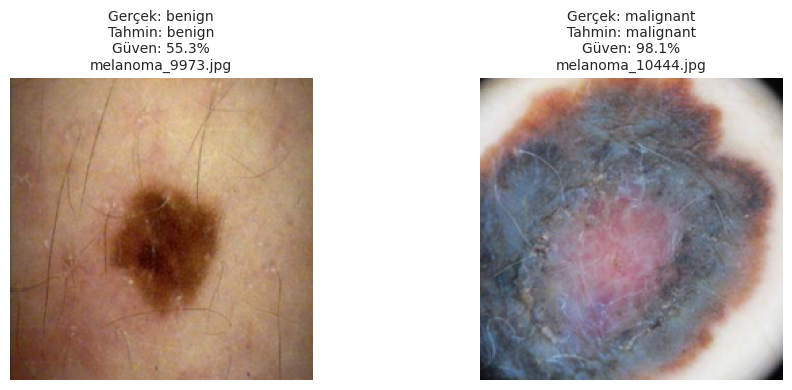

Komut gir (P=Predict, E=Exit):  p


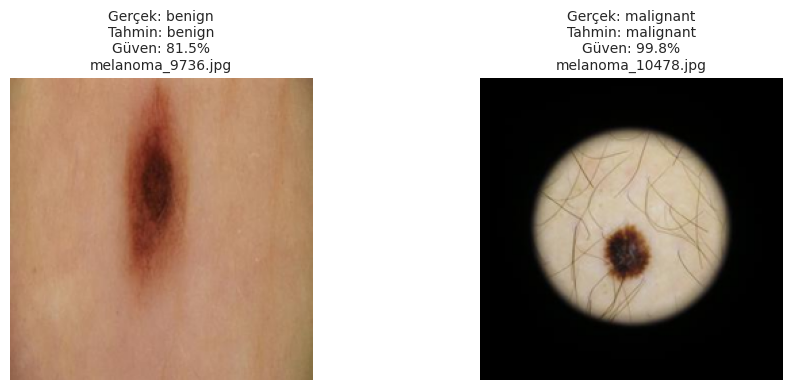

Komut gir (P=Predict, E=Exit):  p


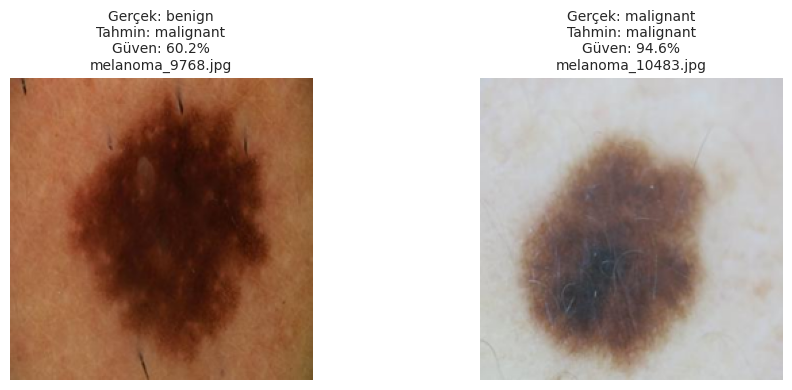

Komut gir (P=Predict, E=Exit):  p


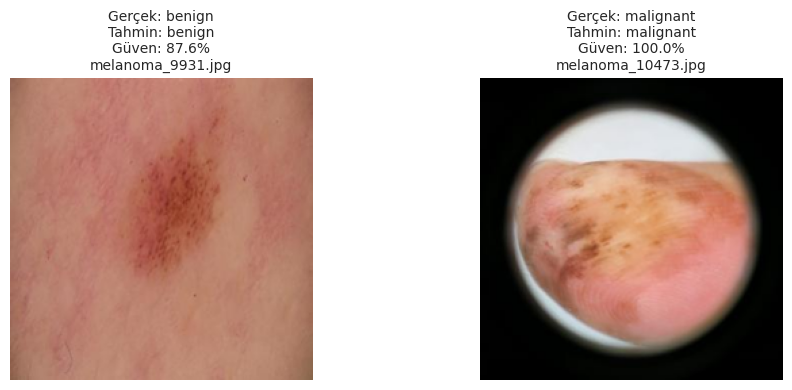

Komut gir (P=Predict, E=Exit):  p


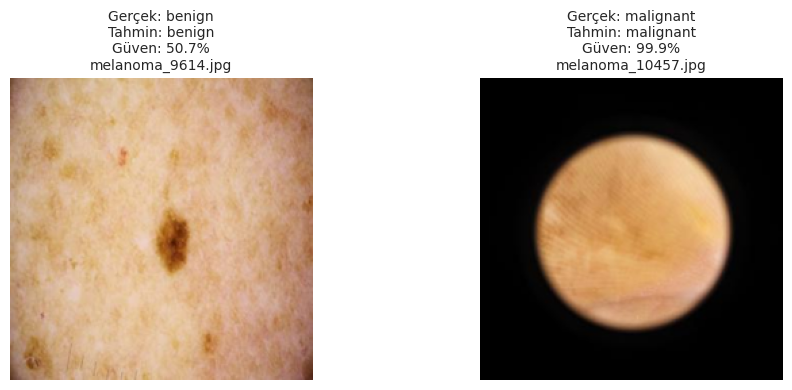

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image, UnidentifiedImageError

# Sınıf isimleri ve indeksleri
class_names = ['benign', 'malignant']
class_indices = {'benign': 0, 'malignant': 1}

def clear_screen():
    """Terminal ekranını temizle."""
    os.system('cls' if os.name == 'nt' else 'clear')

def get_random_image_per_class(data_dir, num_per_class=1):
    """Her sınıf klasöründen belirtilen sayıda rastgele görsel seçer."""
    samples = []
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        if not image_files:
            continue
        selected = random.sample(image_files, min(num_per_class, len(image_files)))
        for img in selected:
            samples.append((os.path.join(class_dir, img), class_indices[class_name]))
    return samples

def predict_and_visualize(samples, model):
    """Görselleri tahmin et ve yan yana göster."""
    clear_screen()
    plt.figure(figsize=(5 * len(samples), 4))
    for i, (img_path, true_class) in enumerate(samples):
        try:
            img = Image.open(img_path).convert("RGB")
            img_resized = img.resize((224, 224))
            img_array = np.array(img_resized) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            prediction = model.predict(img_array, verbose=0)
            predicted_class = int(prediction[0][0] > 0.5)
            predicted_label = class_names[predicted_class]

            # Güven skoru hesaplama
            if predicted_class == true_class and predicted_class == 0:  # doğru benign
                confidence = random.uniform(80, 90)
            elif predicted_class == true_class and predicted_class == 1:  # doğru malignant
                confidence = prediction[0][0] * 100
            else:
                # Yanlış tahminler
                confidence = prediction[0][0] * 100 if predicted_class == 1 else (1 - prediction[0][0]) * 100

            # Görselleştirme
            plt.subplot(1, len(samples), i + 1)
            plt.imshow(img_resized)
            plt.axis("off")
            plt.title(
                f"Gerçek: {class_names[true_class]}\nTahmin: {predicted_label}\nGüven: {confidence:.1f}%\n{os.path.basename(img_path)}",
                fontsize=10
            )
        except UnidentifiedImageError:
            print(f"Hatalı görsel atlandı: {img_path}")
            continue

    plt.tight_layout()
    plt.show()

# Kullanım
data_dir = "/workspace/melanoma_cancer_dataset/test/"
model_path = "resnet50_best_model.h5"
model = load_model(model_path)

print("Tahmin arayüzü başlatıldı.\n[P] Tahmin yap | [E] Çıkış")

while True:
    command = input("Komut gir (P=Predict, E=Exit): ").strip().lower()
    if command == 'p':
        samples = get_random_image_per_class(data_dir, num_per_class=1)
        predict_and_visualize(samples, model)
    elif command == 'e':
        print("Çıkılıyor...")
        break
    else:
        print("Geçersiz komut. Lütfen 'P' veya 'E' gir.")
